In [38]:
import numpy as np
from vispy import plot as vp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
sns.set(style='ticks', color_codes=True)
%matplotlib inline
from math import pi
import warnings
warnings.filterwarnings('ignore')
sns.set_context("notebook")
from pylab import rcParams
plt.rcParams.update({'font.size': 19})
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = 7,4
from statsmodels.graphics.mosaicplot import mosaic
from IPython.display import Image
from IPython.core.display import HTML 
import dask.dataframe as dd
from bokeh.charts import Scatter
from bokeh.charts import Bar
from bokeh.charts import Histogram
from bokeh.charts import BoxPlot
from bokeh.layouts import gridplot

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral6
from bokeh.plotting import figure

css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

Loading BokehJS ...

In [2]:
#list of columns to work with
l = ["mager","mbrace","dmar","meduc","priorlive","priorterm","previs","cig_0","cig_1","cig_2","cig_3","bmi_r","rf_pdiab","rf_phype","ip_gon","ip_syph","ip_chlam","dmeth_rec","dbwt"]
df = dd.read_csv('natl2016.csv')
df.columns = map(str.lower, df.columns) #uncapitalize column headers
df = df[l]
df = df.compute() #convert dataset from Dask dataframe to Pandas

In [3]:
data = df.copy()
data.head()

,mager,mbrace,dmar,meduc,priorlive,priorterm,previs,cig_0,cig_1,cig_2,cig_3,bmi_r,rf_pdiab,rf_phype,ip_gon,ip_syph,ip_chlam,dmeth_rec,dbwt
0,35,1,1,6,3,1,3,0,0,0,0,4,N,N,N,N,N,1,3705
1,32,4,1,7,0,0,10,0,0,0,0,2,N,N,N,N,N,1,3204
2,18,3,2,2,0,1,99,0,0,0,0,2,N,N,N,N,N,1,4499
3,34,1,2,4,0,0,15,99,99,99,99,4,N,N,N,N,N,1,3660
4,31,4,1,6,2,0,9,0,0,0,0,2,N,N,N,N,N,1,2866


In [4]:
#Rename columns to become more readable
data.columns = ["Age","Race","Marriage_Status","Education","Kids","Terminations","Prenatal_Visits","Cig_Before","Tri_1","Tri_2","Tri_3","BMI","Diabetes","Hypertension","Gonorrhea","Syphilis","Chlamydia","Delivery","Weight"]

#change column data from mapped numbers to actual terms
data["Race"] = data["Race"].map({1:"White",2:"Black",3:"American Indian/Alaskan Native",4:"Asian/Pacific Islander"})
data["Marriage_Status"] = data["Marriage_Status"].map({1:"Married",2:"Unmarried"})
data["Education"] = data["Education"].map({1:"<9th grade",2:"9th-12th grade",3:"High school graduate/GED",4:"Some college credit",5:"Associate degree",6:"Bachelor’s degree",7:"Master’s degree",8:"Doctorate/Professional Degree",9:"Unknown"})
data["BMI"] = data["BMI"].map({1:"Underweight",2:"Normal",3:"Overweight",4:"Obesity I",5:"Obesity II",6:"Extreme Obesity III",9:"Unknown"})
data["Delivery"] = data["Delivery"].map({1:"Vaginal",2:"C-Section",9:"Unknown"})

data.head()

,Age,Race,Marriage_Status,Education,Kids,Terminations,Prenatal_Visits,Cig_Before,Tri_1,Tri_2,Tri_3,BMI,Diabetes,Hypertension,Gonorrhea,Syphilis,Chlamydia,Delivery,Weight
0,35,White,Married,Bachelor’s degree,3,1,3,0,0,0,0,Obesity I,N,N,N,N,N,Vaginal,3705
1,32,Asian/Pacific Islander,Married,Master’s degree,0,0,10,0,0,0,0,Normal,N,N,N,N,N,Vaginal,3204
2,18,American Indian/Alaskan Native,Unmarried,9th-12th grade,0,1,99,0,0,0,0,Normal,N,N,N,N,N,Vaginal,4499
3,34,White,Unmarried,Some college credit,0,0,15,99,99,99,99,Obesity I,N,N,N,N,N,Vaginal,3660
4,31,Asian/Pacific Islander,Married,Bachelor’s degree,2,0,9,0,0,0,0,Normal,N,N,N,N,N,Vaginal,2866


In [5]:
cats = ["Diabetes","Hypertension","Gonorrhea","Syphilis","Chlamydia","Education","BMI","Delivery"]
vals = ["Kids","Terminations","Prenatal_Visits","Cig_Before","Tri_1","Tri_2","Tri_3"]

#Remove all rows where data is unusable/unknown
data = data[(data["Kids"] != 99) & (data["Terminations"] != 99) & (data["Prenatal_Visits"] != 99) & (data["Cig_Before"] != 99) & (data["Tri_1"] != 99) & (data["Tri_2"] != 99) & (data["Tri_3"] != 99) & (data["Weight"] != 9999)]

#Same as before, changing the data to actual terms
for each in cats:
    data[each] = data[each].astype(str).replace(["Y","N","U"],["Yes","No","Unknown"])

#Removing all rows where data is unusable/unknown
data = data[(data["Diabetes"] != "Unknown") & (data["Hypertension"] != "Unknown") & (data["Gonorrhea"] != "Unknown") & (data["Syphilis"] != "Unknown") & (data["Chlamydia"] != "Unknown") & (data["BMI"] != "Unknown") & (data["Delivery"] != "Unknown") & (data["Education"] != "Unknown")]
data = data.reset_index(drop=True)
data["Weight"] = data["Weight"] *0.00220462 #Converting baby weight from grams to pounds

In [6]:
categories = ["Race","Marriage_Status","Education","BMI","Diabetes","Hypertension","Gonorrhea","Syphilis","Chlamydia","Delivery"]
values = ["Age","Kids","Terminations","Prenatal_Visits","Cig_Before","Tri_1","Tri_2","Tri_3"]

#Optimizing data set, converting Object to Category dtype
for each in categories:
    data[each] = data[each].astype('category')

#Optimizing data set, converting int64 to int8 dtype    
for each in values:
    data[each] = data[each].astype('int8')
    
data["Weight"] = data["Weight"].astype("float16")
    
print(data.dtypes)
data.head()

Age                    int8
Race               category
Marriage_Status    category
Education          category
Kids                   int8
Terminations           int8
Prenatal_Visits        int8
Cig_Before             int8
Tri_1                  int8
Tri_2                  int8
Tri_3                  int8
BMI                category
Diabetes           category
Hypertension       category
Gonorrhea          category
Syphilis           category
Chlamydia          category
Delivery           category
Weight              float16
dtype: object


,Age,Race,Marriage_Status,Education,Kids,Terminations,Prenatal_Visits,Cig_Before,Tri_1,Tri_2,Tri_3,BMI,Diabetes,Hypertension,Gonorrhea,Syphilis,Chlamydia,Delivery,Weight
0,35,White,Married,Bachelor’s degree,3,1,3,0,0,0,0,Obesity I,No,No,No,No,No,Vaginal,8.171875
1,32,Asian/Pacific Islander,Married,Master’s degree,0,0,10,0,0,0,0,Normal,No,No,No,No,No,Vaginal,7.062500
2,31,Asian/Pacific Islander,Married,Bachelor’s degree,2,0,9,0,0,0,0,Normal,No,No,No,No,No,Vaginal,6.320312
3,33,White,Married,Some college credit,2,0,9,0,0,0,0,Overweight,No,No,No,No,No,Vaginal,9.671875
4,28,Asian/Pacific Islander,Married,High school graduate/GED,8,0,3,0,0,0,0,Overweight,No,No,No,No,No,Vaginal,1.697266


In [7]:
#What factors matter most when it comes to Prenatal Care
pre_natal = data[["Age","Race","Marriage_Status","Education","Kids","Prenatal_Visits"]].copy()
pre_natal.head()

,Age,Race,Marriage_Status,Education,Kids,Prenatal_Visits
0,35,White,Married,Bachelor’s degree,3,3
1,32,Asian/Pacific Islander,Married,Master’s degree,0,10
2,31,Asian/Pacific Islander,Married,Bachelor’s degree,2,9
3,33,White,Married,Some college credit,2,9
4,28,Asian/Pacific Islander,Married,High school graduate/GED,8,3


In [8]:
pre_natal.corr() #Checking if there's any strong correlation between variables

,Age,Kids,Prenatal_Visits
Age,1.000000,0.317675,0.094284
Kids,0.317675,1.000000,-0.100208
Prenatal_Visits,0.094284,-0.100208,1.000000


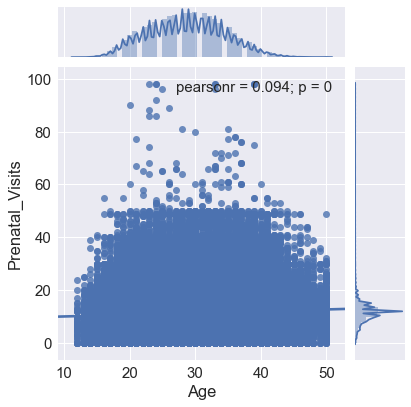

In [ ]:
pre_age = sns.JointGrid(x=pre_natal.Age,y=pre_natal.Prenatal_Visits)
pre_age = pre_age.plot(sns.regplot, sns.distplot)
pre_age = pre_age.annotate(stats.pearsonr)

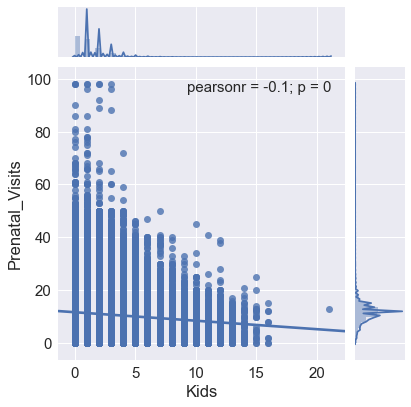

In [9]:
pre_kids = sns.JointGrid(x=pre_natal.Kids,y=pre_natal.Prenatal_Visits)
pre_kids = pre_kids.plot(sns.regplot, sns.distplot)
pre_kids = pre_kids.annotate(stats.pearsonr)

In [10]:
pre_race = Bar(pre_natal, label='Race', values='Prenatal_Visits', agg='mean', 
        title="Average Prenatal Visits, grouped by Race", 
        legend=None, 
        tools='crosshair',
        plot_width=400, plot_height=400)
show(pre_race)

In [39]:
x=pre_natal.Race
y=pre_natal.Prenatal_Visits.mean()
def exp_z_inv(x, y):
    z = np.complex(x, y)
    f = np.exp(1.0 / z)
    return np.angle(f, deg=True)


# create a 2d grid whose elements are of exp_z_inv
def gen_image(width, height):
    x_vals = np.linspace(-0.5, 0.5, width)
    y_vals = np.linspace(-0.5, 0.5, height)

    grid = np.meshgrid(x_vals, y_vals)
    v_fn = np.vectorize(exp_z_inv)

    return v_fn(*grid).astype(np.float)

fig = vp.Fig(size=(800, 600), show=False)
plot = fig[0, 0]
plot.bgcolor = "#efefef"

img = gen_image(500, 500)
plot.image(img, cmap="hsl")
plot.camera.set_range((100, 400), (100, 400))

positions = ["top", "bottom", "left", "right"]

for position in positions:
    plot.colorbar(position=position,
                  label="argument of e^(1/z)",
                  clim=("0°", "180°"),
                  cmap="hsl",
                  border_width=1,
                  border_color="#aeaeae")
if __name__ == '__main__':
    fig.show(run=True)

In [11]:
pre_marriage = Bar(pre_natal, label='Marriage_Status', values='Prenatal_Visits', agg='mean', 
        title="Average Prenatal Visits, grouped by Marriage Status", 
        legend=None, 
        tools='crosshair',
        plot_width=400, plot_height=400)
show(pre_marriage)

In [12]:
pre_educ = Bar(pre_natal, label='Education', values='Prenatal_Visits', agg='mean', 
        title="Average Prenatal Visits, grouped by Education Status", 
        legend=None, 
        tools='crosshair',
        plot_width=400, plot_height=400)
show(pre_educ)

In [13]:
#Calculating the difference of the means for each column in the data 
#Determines the dispersion of the data, therefore showing what has the greatest effect on Prenatal Visits
#Used to make graphs
age = pre_natal.groupby("Age").Prenatal_Visits.mean().diff().abs().dropna()
race = pre_natal.groupby("Race").Prenatal_Visits.mean().diff().abs().dropna()
marriage = pre_natal.groupby("Marriage_Status").Prenatal_Visits.mean().diff().abs().dropna()
education = pre_natal.groupby("Education").Prenatal_Visits.mean().diff().abs().dropna()
kids = pre_natal.groupby("Kids").Prenatal_Visits.mean().diff().abs().dropna()

In [14]:
age_val = pre_natal.groupby("Age").Prenatal_Visits.mean().diff().abs().mean()
race_val = pre_natal.groupby("Race").Prenatal_Visits.mean().diff().abs().mean()
marriage_val = pre_natal.groupby("Marriage_Status").Prenatal_Visits.mean().diff().abs().mean()
education_val = pre_natal.groupby("Education").Prenatal_Visits.mean().diff().abs().mean()
kids_val = pre_natal.groupby("Kids").Prenatal_Visits.mean().diff().abs().mean()

print(age_val,race_val,marriage_val,education_val,kids_val)

0.15462705718866881 1.0090178121540767 0.9773948218768016 0.7708586403678007 0.8704019825976156


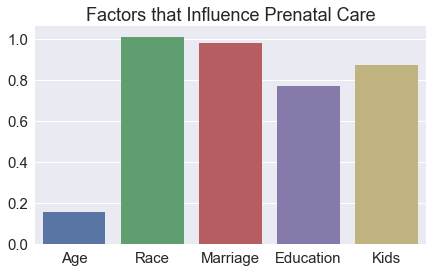

In [15]:
age_list = ["Age","Race","Marriage","Education","Kids"]
age_values = [age_val,race_val,marriage_val,education_val,kids_val]
sns.barplot(x=age_list, y=age_values).set_title("Factors that Influence Prenatal Care")

In [16]:
#How does childbirths vary across demographics
age_data = data[["Age","Terminations","Race","Marriage_Status","Education"]].copy()
age_data.head()

,Age,Terminations,Race,Marriage_Status,Education
0,35,1,White,Married,Bachelor’s degree
1,32,0,Asian/Pacific Islander,Married,Master’s degree
2,31,0,Asian/Pacific Islander,Married,Bachelor’s degree
3,33,0,White,Married,Some college credit
4,28,0,Asian/Pacific Islander,Married,High school graduate/GED


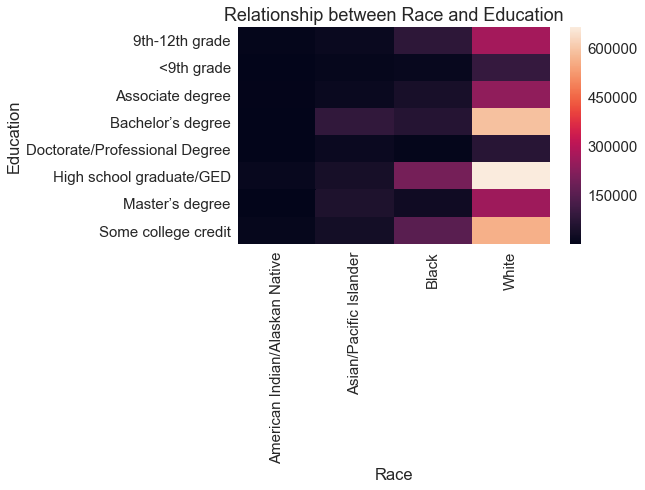

In [17]:
ct_Race_ed = pd.crosstab(age_data.Education,age_data.Race)
sns.heatmap(ct_Race_ed).set_title("Relationship between Race and Education")

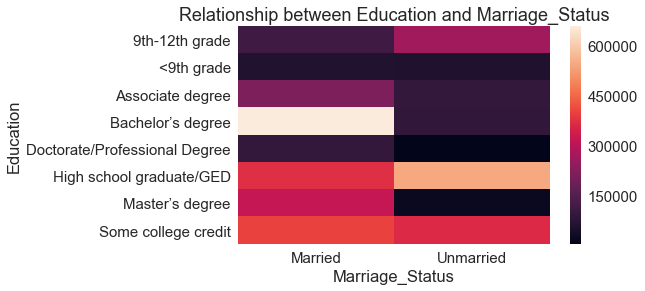

In [18]:
ct = pd.crosstab(age_data.Education,age_data.Marriage_Status)
sns.heatmap(ct).set_title("Relationship between Education and Marriage_Status")

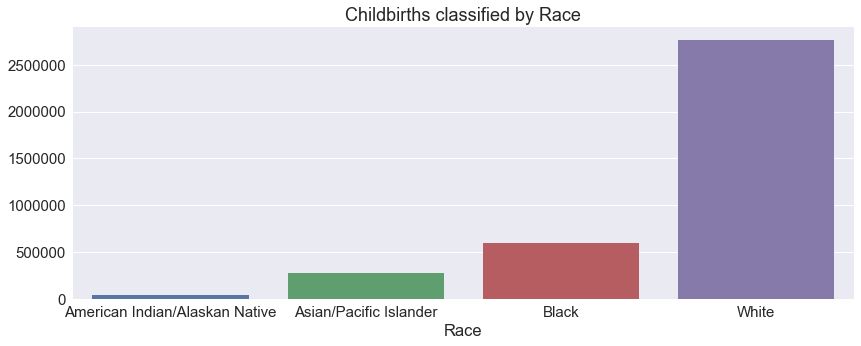

In [19]:
total = age_data.groupby("Race").count().Age
sns.barplot(x=total.index, y=total.values).set_title("Childbirths classified by Race").figure.set_size_inches(14,5)


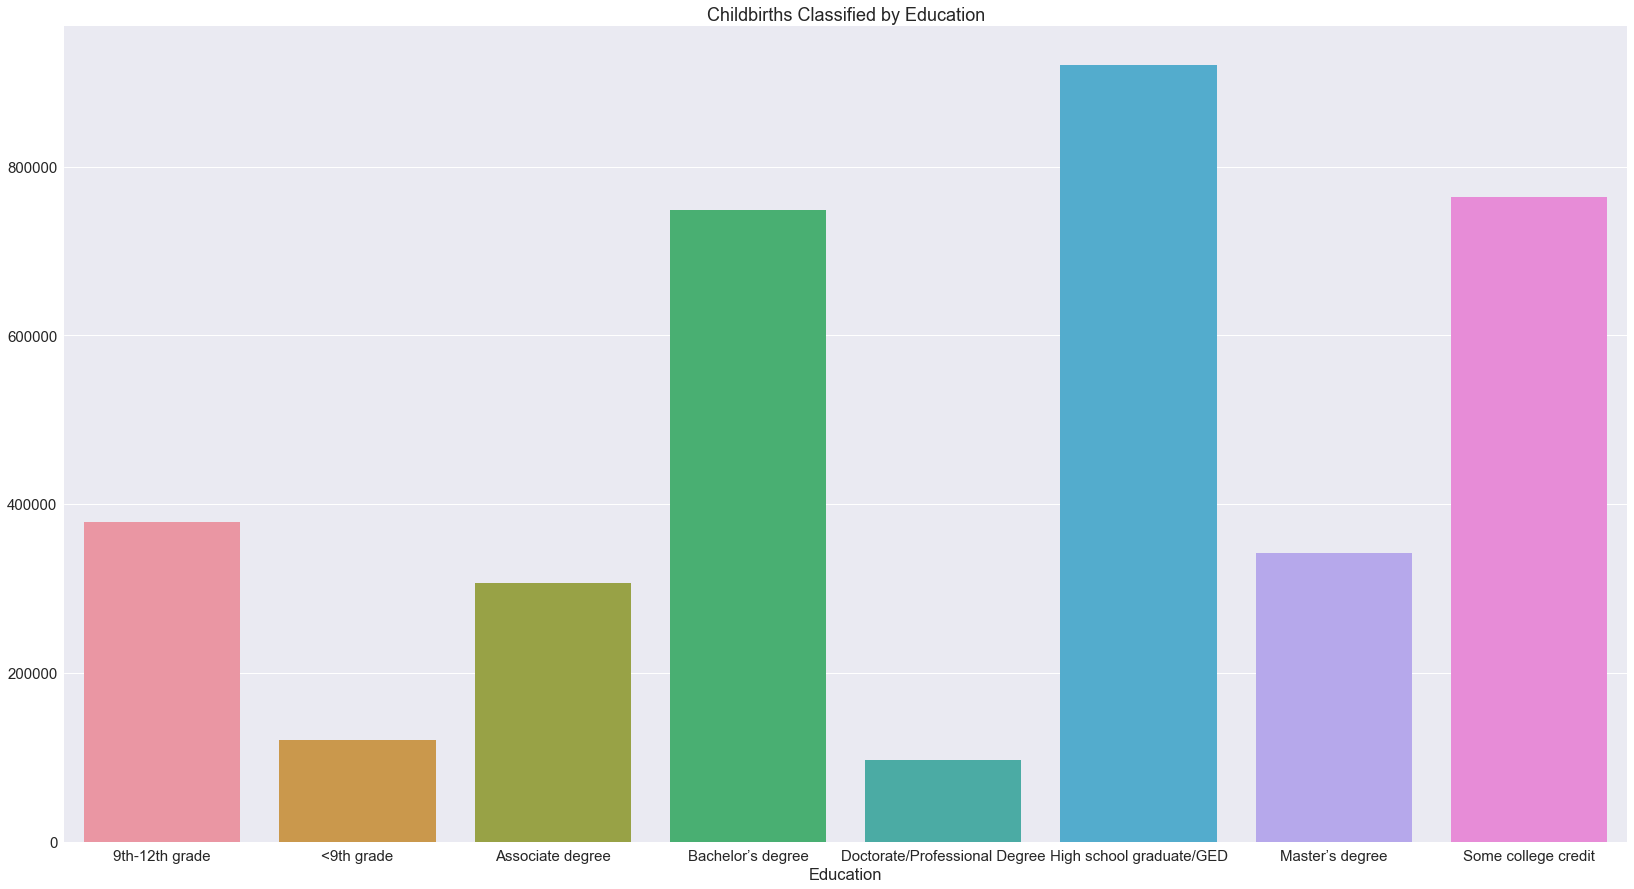

In [20]:
total = age_data.groupby("Education").count().Age
sns.barplot(x=total.index, y=total.values).set_title("Childbirths Classified by Education").figure.set_size_inches(28,15)

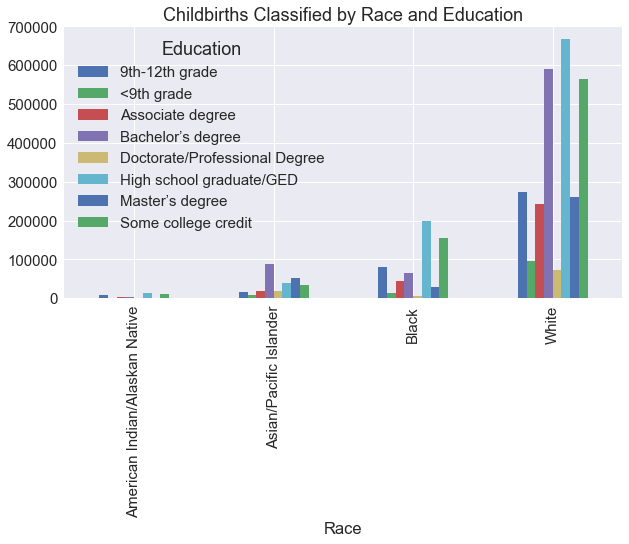

In [21]:
total = age_data.groupby(["Education","Race"]).count().Age
total.unstack(level=0).plot(kind='bar').set_title("Childbirths Classified by Race and Education").figure.set_size_inches(10,5)

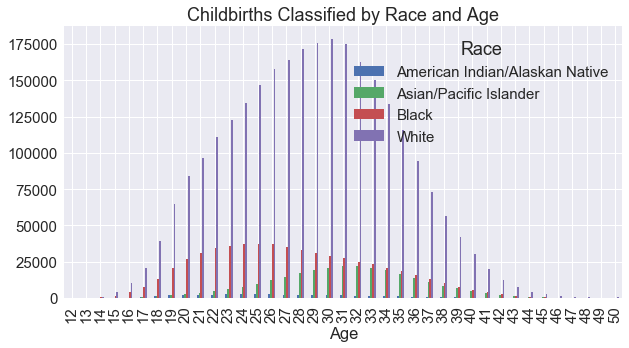

In [22]:
total = age_data.groupby(["Race","Age"]).count().Education
total.unstack(level=0).plot(kind='bar').set_title("Childbirths Classified by Race and Age").figure.set_size_inches(10,5)

In [23]:
#How does Tobacco use affect childbirth
smoke_data = data[["Cig_Before","Tri_1","Tri_2","Tri_3","Delivery","Weight"]].copy()
smoke_data.head()

,Cig_Before,Tri_1,Tri_2,Tri_3,Delivery,Weight
0,0,0,0,0,Vaginal,8.171875
1,0,0,0,0,Vaginal,7.062500
2,0,0,0,0,Vaginal,6.320312
3,0,0,0,0,Vaginal,9.671875
4,0,0,0,0,Vaginal,1.697266


In [24]:
smoke_data.corr()

,Cig_Before,Tri_1,Tri_2,Tri_3,Weight
Cig_Before,1.000000,0.799137,0.708615,0.651705,-0.065405
Tri_1,0.799137,1.000000,0.877193,0.809360,-0.075205
Tri_2,0.708615,0.877193,1.000000,0.924732,-0.076450
Tri_3,0.651705,0.809360,0.924732,1.000000,-0.072902
Weight,-0.065405,-0.075205,-0.076450,-0.072902,1.000000


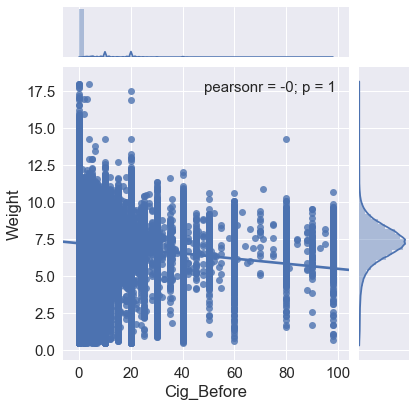

In [26]:
smoke = sns.JointGrid(x=smoke_data.Cig_Before,y=smoke_data.Weight)
smoke = smoke.plot(sns.regplot, sns.distplot)
smoke = smoke.annotate(stats.pearsonr)

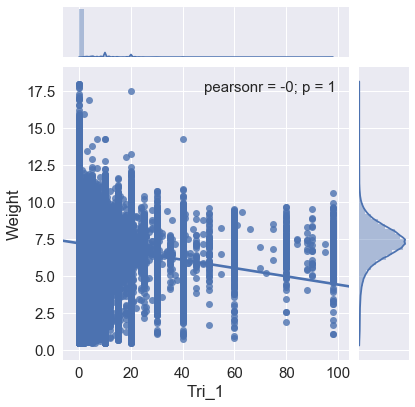

In [27]:
smoke = sns.JointGrid(x=smoke_data.Tri_1,y=smoke_data.Weight)
smoke = smoke.plot(sns.regplot, sns.distplot)
smoke = smoke.annotate(stats.pearsonr)

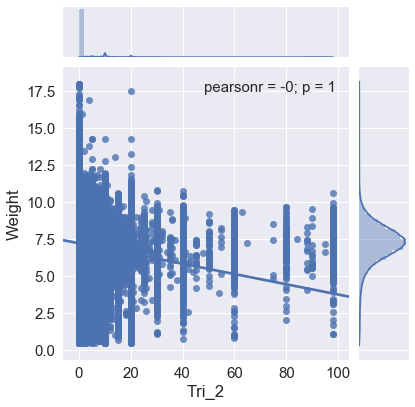

In [28]:
smoke = sns.JointGrid(x=smoke_data.Tri_2,y=smoke_data.Weight)
smoke = smoke.plot(sns.regplot, sns.distplot)
smoke = smoke.annotate(stats.pearsonr)

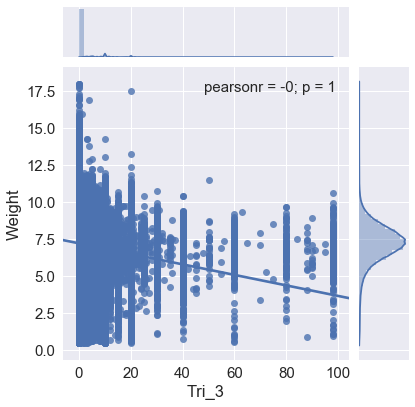

In [29]:
smoke = sns.JointGrid(x=smoke_data.Tri_3,y=smoke_data.Weight)
smoke = smoke.plot(sns.regplot, sns.distplot)
smoke = smoke.annotate(stats.pearsonr)

In [30]:
#How does other risk factors affect childbirth
risk_data = data[["BMI","Diabetes","Hypertension","Gonorrhea","Syphilis","Chlamydia","Delivery","Weight"]].copy()
risk_data.head()

,BMI,Diabetes,Hypertension,Gonorrhea,Syphilis,Chlamydia,Delivery,Weight
0,Obesity I,No,No,No,No,No,Vaginal,8.171875
1,Normal,No,No,No,No,No,Vaginal,7.062500
2,Normal,No,No,No,No,No,Vaginal,6.320312
3,Overweight,No,No,No,No,No,Vaginal,9.671875
4,Overweight,No,No,No,No,No,Vaginal,1.697266


In [31]:
risk_data.groupby(["BMI","Delivery"]).Delivery.count()

BMI                  Delivery 
Extreme Obesity III  C-Section      95333
                     Vaginal        85074
Normal               C-Section     422376
                     Vaginal      1206969
Obesity I            C-Section     201573
                     Vaginal       325078
Obesity II           C-Section     113042
                     Vaginal       142757
Overweight           C-Section     312277
                     Vaginal       645983
Underweight          C-Section      27872
                     Vaginal       100305
Name: Delivery, dtype: int64

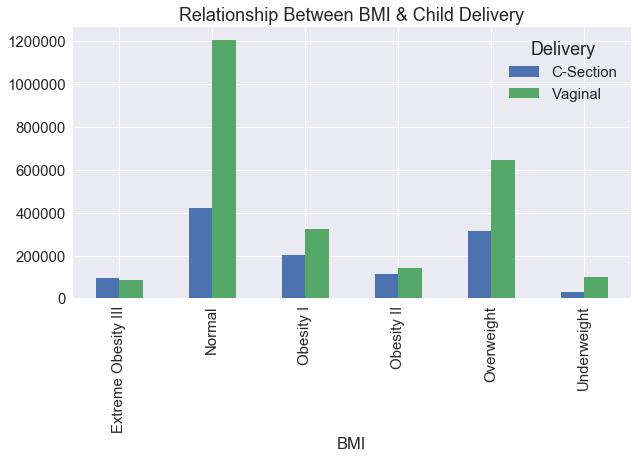

In [32]:
total = risk_data.groupby(["Delivery","BMI"]).Delivery.count()
total.unstack(level=0).plot(kind='bar').set_title("Relationship Between BMI & Child Delivery").figure.set_size_inches(10,5)

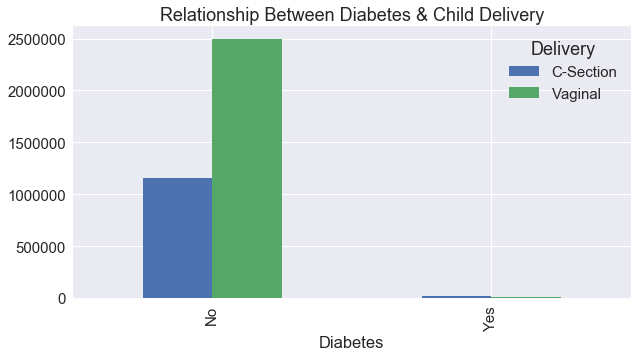

In [33]:
risk_data.groupby(["Diabetes","Delivery"]).Delivery.count()
total = risk_data.groupby(["Delivery","Diabetes"]).Delivery.count()
total.unstack(level=0).plot(kind='bar').set_title("Relationship Between Diabetes & Child Delivery").figure.set_size_inches(10,5)

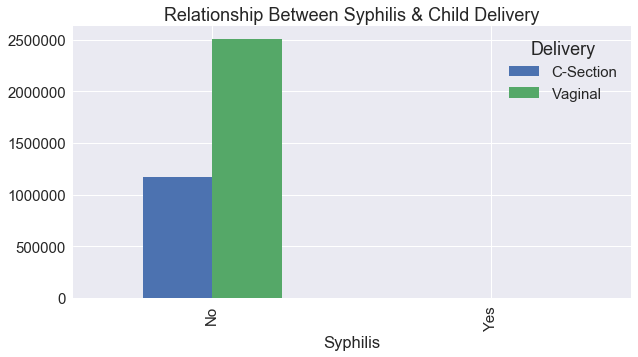

In [34]:
risk_data.groupby(["Syphilis","Delivery"]).Delivery.count()
total = risk_data.groupby(["Delivery","Syphilis"]).Delivery.count()
total.unstack(level=0).plot(kind='bar').set_title("Relationship Between Syphilis & Child Delivery").figure.set_size_inches(10,5)

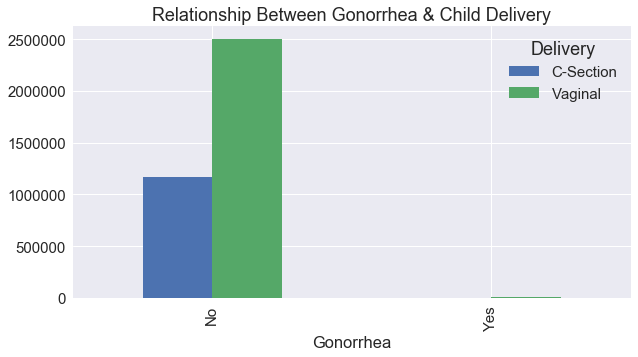

In [35]:
risk_data.groupby(["Gonorrhea","Delivery"]).Delivery.count()
total = risk_data.groupby(["Delivery","Gonorrhea"]).Delivery.count()
total.unstack(level=0).plot(kind='bar').set_title("Relationship Between Gonorrhea & Child Delivery").figure.set_size_inches(10,5)

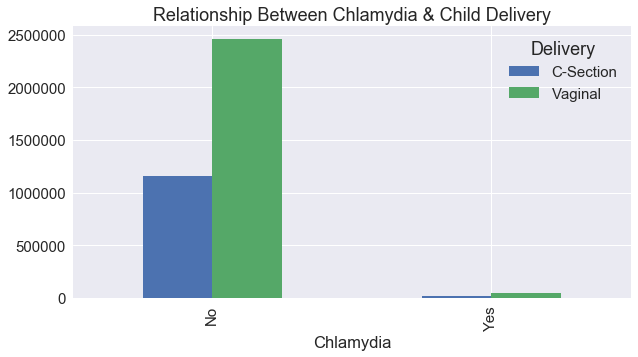

In [36]:
risk_data.groupby(["Chlamydia","Delivery"]).Delivery.count()
total = risk_data.groupby(["Delivery","Chlamydia"]).Delivery.count()
total.unstack(level=0).plot(kind='bar').set_title("Relationship Between Chlamydia & Child Delivery").figure.set_size_inches(10,5)

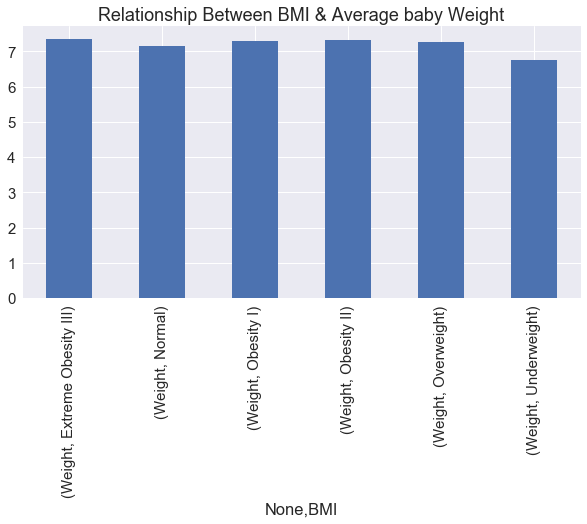

In [37]:
risk_data.groupby("BMI").mean()
total = risk_data.groupby(["BMI"]).mean()
total
total.unstack(level=0).plot(kind='bar').set_title("Relationship Between BMI & Average baby Weight").figure.set_size_inches(10,5)